In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
import keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
xray_data = pd.read_csv('/content/drive/MyDrive/Data_Entry_2017.csv')

# see how many observations there are
num_obs = len(xray_data)
print('Number of observations:',num_obs)

# examine the raw data before performing pre-processing
xray_data.head(5) # view first 5 rows
#xray_data.sample(5) # view 5 randomly sampled rows

Number of observations: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
from glob import glob
#import os # already imported earlier

my_glob = glob('C:/input/images*/images/*.png')
print('Number of Observations: ', len(my_glob)) # check to make sure I've captured every pathway, should equal 112,120

Number of Observations:  112120


In [ ]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
xray_data['full_path'] = xray_data['Image Index'].map(full_img_paths.get)


In [ ]:
num_unique_labels = xray_data['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels)

# let's look at the label distribution to better plan our next step
count_per_unique_label = xray_data['Finding Labels'].value_counts() # get frequency counts per label
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes


Number of unique labels: 836


In [ ]:
print(df_count_per_unique_label) # view tabular results

                                                    Finding Labels
No Finding                                                   60361
Infiltration                                                  9547
Atelectasis                                                   4215
Effusion                                                      3955
Nodule                                                        2705
Pneumothorax                                                  2194
Mass                                                          2139
Effusion|Infiltration                                         1603
Atelectasis|Infiltration                                      1350
Consolidation                                                 1310
Atelectasis|Effusion                                          1165
Pleural_Thickening                                            1126
Cardiomegaly                                                  1093
Emphysema                                                     

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

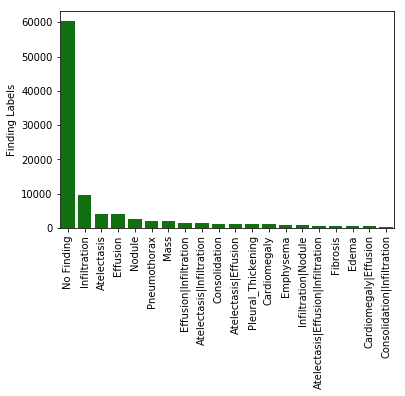

In [ ]:
sns.barplot(x = df_count_per_unique_label.index[:20], y="Finding Labels", data=df_count_per_unique_label[:20], color = "green")
plt.xticks(rotation = 90) 

In [ ]:
# define dummy labels for one hot encoding - simplifying to 14 primary classes (excl. No Finding)
dummy_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# One Hot Encoding of Finding Labels to dummy_labels
for label in dummy_labels:
    xray_data[label] = xray_data['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
xray_data.head(20) # check the data, looking good!

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,full_path,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000003_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN,../input/images_001/images/00000003_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN,../input/images_001/images/00000003_003.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000003_004.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN,../input/images_001/images/00000003_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Infiltration          19894.0
Effusion              13317.0
Atelectasis           11559.0
Nodule                 6331.0
Mass                   5782.0
Pneumothorax           5302.0
Consolidation          4667.0
Pleural_Thickening     3385.0
Cardiomegaly           2776.0
Emphysema              2516.0
Edema                  2303.0
Fibrosis               1686.0
Pneumonia              1431.0
Hernia                  227.0
dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x7f407baa7208>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
  <a list of 14 Text xticklabel objects>))

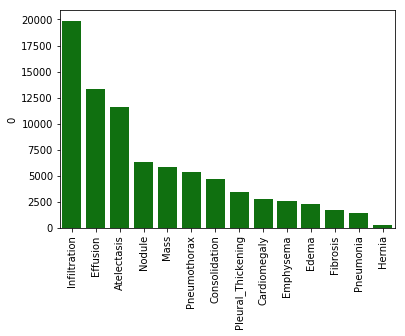

In [ ]:
clean_labels = xray_data[dummy_labels].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [ ]:
## MODEL CREATION PHASE STARTS HERE

# create vector as ground-truth, will use as actuals to compare against our predictions later
xray_data['target_vector'] = xray_data.apply(lambda target: [target[dummy_labels].values], 1).map(lambda target: target[0])

In [ ]:
xray_data.head() 


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,full_path,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,target_vector
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/images_001/images/00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/images_001/images/00000001_001.png,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/images_001/images/00000001_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# split the data into a training and testing set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(xray_data, test_size = 0.2, random_state = 1993)

# quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_set))
print('test set - # of observations): ', len(test_set))
print('prior, full data set - # of observations): ', len(xray_data))

training set - # of observations:  89696
test set - # of observations):  22424
prior, full data set - # of observations):  112120


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
image_size = (128, 128) # image re-sizing target

train_gen = flow_from_dataframe(data_gen, train_set, path_col = 'full_path', y_col = 'target_vector', 
                                target_size = image_size, 
                                color_mode = 'rgb',
                                batch_size = 32)

valid_gen = flow_from_dataframe(data_gen, test_set, path_col = 'full_path', y_col = 'target_vector', 
                                target_size = image_size, 
                                color_mode = 'rgb', 
                                batch_size = 128)

# define test sets
test_X, test_Y = next(flow_from_dataframe(data_gen, test_set, path_col = 'full_path', y_col = 'target_vector', 
                                          target_size = image_size, 
                                          color_mode = 'rgb', 
                                          batch_size = 2048))

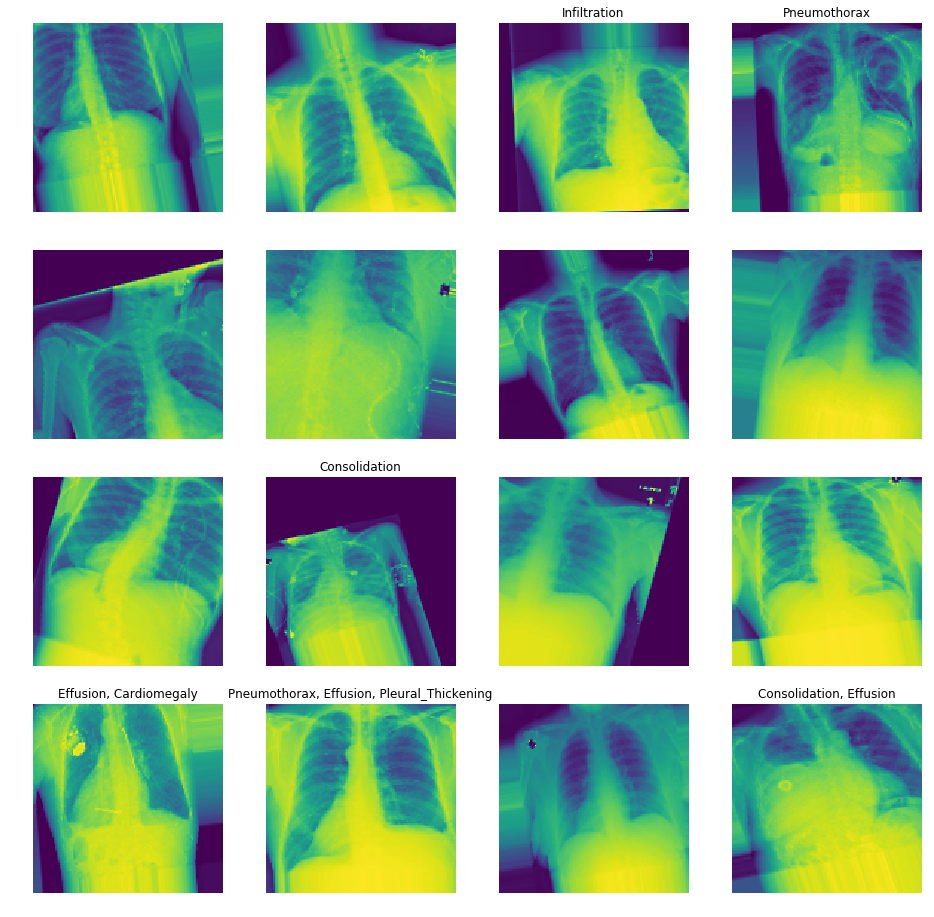

In [ ]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0])
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(dummy_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')


**MobileNet**

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(dummy_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                7182      
Total params: 3,760,846
Trainable params: 3,738,958
Non-trainable params: 21,888
_____________________________________________________________

In [ ]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X,test_Y), 
                                  epochs = 10)
                                  

Epoch 1/10
100/100 [==============================] - 113s 1s/step - loss: 0.2737 - binary_accuracy: 0.9404 - mean_absolute_error: 0.0950 - val_loss: 0.5199 - val_binary_accuracy: 0.9486 - val_mean_absolute_error: 0.0639
Epoch 2/10
100/100 [==============================] - 110s 1s/step - loss: 0.2391 - binary_accuracy: 0.9477 - mean_absolute_error: 0.0937 - val_loss: 0.3550 - val_binary_accuracy: 0.9265 - val_mean_absolute_error: 0.1007
Epoch 3/10
100/100 [==============================] - 110s 1s/step - loss: 0.2218 - binary_accuracy: 0.9470 - mean_absolute_error: 0.0948 - val_loss: 0.1910 - val_binary_accuracy: 0.9486 - val_mean_absolute_error: 0.1012
Epoch 4/10
100/100 [==============================] - 109s 1s/step - loss: 0.1973 - binary_accuracy: 0.9466 - mean_absolute_error: 0.0981 - val_loss: 0.2016 - val_binary_accuracy: 0.9486 - val_mean_absolute_error: 0.0701
Epoch 5/10
100/100 [==============================] - 109s 1s/step - loss: 0.1922 - binary_accuracy: 0.9476 - mean_a

In [ ]:
multi_disease_model.save('mobilenet.h5')

In [ ]:
from keras.models import load_model 
multi_disease = load_model('mobilenet.h5')

In [ ]:
test_X.shape

(2048, 128, 128, 3)

In [ ]:
sample_image = test_X[0]

In [ ]:
sample_image = sample_image.reshape((1, 128,128,3))

In [ ]:
multi_disease_model.predict(sample_image)

array([[0.07537966, 0.01354615, 0.12978166, 0.01672724, 0.00319527,
        0.00861273, 0.00726164, 0.04485592, 0.00326088, 0.01290023,
        0.01191583, 0.03520777, 0.0273827 , 0.00063632]], dtype=float32)

In [ ]:
y_pred = multi_disease_model.predict(test_X)

In [ ]:
print('test binary accuracy = ',multi_disease_model.evaluate(test_X,test_Y, verbose=0)[1])

test binary accuracy =  0.9486258402466774
